In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
import sys
sys.path.insert(1, "..")
import os
import json
import random
import torch
from main_code.utils.data.data_sets import DiskTSPTestSet
from main_code.utils.visualization.tsp_plotter import TSP_plotter

In [3]:
def extract_node_coords(tsp_instance, num_nodes):
    derivate = tsp_instance.split(' ')
    x = np.array(derivate[0:2*num_nodes:2], dtype = np.float64).reshape((-1,1))
    y = np.array(derivate[1:2*num_nodes:2], dtype = np.float64).reshape((-1,1))
    coords = np.concatenate((x, y), axis=1)
    return coords

def extract_sol(tsp_instance, num_nodes):
    derivate = tsp_instance.split(' ')
    opt_sol = np.array(derivate[2*num_nodes+1:-1], dtype = np.int32) - 1 
    return opt_sol[0:num_nodes]

In [4]:
# extract data
num_nodes = 1000
f = open('../data/test_sets/fu_et_al_original/tsp{}_test_concorde.txt'.format(num_nodes), 'r')
testset_tsp = f.readlines()
f.close()
num_samples = len(testset_tsp)
# general save path
test_set_name = f"fu_et_al_n_{num_nodes}_{num_samples}"
save_path = f"../data/test_sets/{test_set_name}"

FileNotFoundError: [Errno 2] No such file or directory: '../data/test_sets/fu_et_al/tsp1000_test_concorde.txt'

In [ ]:
def calc_length(node_feats, sol):
    length = 0
    for i in range(sol.shape[0] - 1):
        first = sol[i]
        sec = sol[i+1]
        difference = node_feats[first] - node_feats[sec]
        # print(difference)
        summed_square = np.sum(np.square(difference))
        # print(summed_square)
        length += np.sqrt(summed_square)
    length += np.sqrt(np.sum(np.square(node_feats[sol[0]] - node_feats[sol[-1]])))
    return length

def calc_tour_length(node_feats, sol):
    # calculate length of the tour
    differences = node_feats[sol,:] - np.roll(node_feats[sol,:], shift=-1, axis=0)
    summed_squares = np.sum(np.square(differences), axis=1)
    length = np.sum(np.sqrt(summed_squares))
    return length


In [ ]:
def save_tsp_data(tsp_instance, save_path, idx, num_samples):
    # save everything
    idx_str = f'{idx}'.zfill(len(str(num_samples)))
    problem_name = f'tsp_{idx_str}'
    instance_path = f'{save_path}/{problem_name}'
    if not os.path.exists(instance_path):
        os.makedirs(instance_path)
    node_feats = extract_node_coords(tsp_instance, num_nodes=num_nodes)
    np.savetxt(f'{instance_path}/node_feats.txt', node_feats)
    sol = extract_sol(tsp_instance, num_nodes)

    length = calc_tour_length(node_feats, sol)

    # save solution data to folder
    solution_data = {
        'problem_name': problem_name,
        'opt_tour_length': length,
        'opt_tour': sol.tolist()
    }
    with open(f"{instance_path}/solution.json", 'w') as f:
        # indent=2 is not needed but makes the file human-readable
        json.dump(solution_data, f, indent=2)

In [ ]:
for idx, tsp_instance in enumerate(testset_tsp):
    save_tsp_data(save_path, idx, num_samples)

# Sample small sub test set

In [ ]:
dataset_path = "../data/test_sets/fu_et_al_n_100_10000"
dataset =  DiskTSPTestSet(dataset_path, use_pomo_aug=False, sampling_steps=1)

In [ ]:
random.seed(37)
indices = random.sample(range(len(dataset)), 128)
subset = torch.utils.data.Subset(dataset, indices)

In [ ]:
subset[0][2]

array([ 0, 75, 54, 60, 51, 36, 53, 48,  5, 66, 73, 42, 47, 56, 82, 85, 81,
       68, 92, 95, 35, 12, 96, 41, 62, 19, 58, 11, 88, 55, 26, 29, 71, 37,
       23, 20, 97,  1, 25, 83, 50,  4, 33, 59, 80,  3, 24, 32, 63, 38, 46,
       10, 34, 40, 43, 14, 17, 69, 21, 27, 79, 31, 78, 49, 57, 74, 16, 84,
        2, 65, 39, 45, 44, 87, 94, 70, 86, 22, 64, 77, 89, 67,  7, 72, 99,
       90, 18, 76,  8, 93, 52, 13, 91,  6, 61,  9, 28, 15, 98, 30])

In [ ]:
# save subset into new folder
def sample_and_save_subset(dataset, save_path, seed=37):
    random.seed(37)
    indices = random.sample(range(len(dataset)), 128)
    subset = torch.utils.data.Subset(dataset, indices)
    # save data in new folder
    # make sure length stays the same
    for idx, data in enumerate(subset):
        idx_str = f'{idx}'.zfill(len(str(len(subset))))
        problem_name = f'tsp_{idx_str}'
        instance_path = f'{save_path}/{problem_name}'
        if not os.path.exists(instance_path):
            os.makedirs(instance_path) 
        node_feats = data[0]
        np.savetxt(f'{instance_path}/node_feats.txt', node_feats)
        sol = data[2]
        length = calc_tour_length(node_feats, sol)
        assert(data[1] == length)
        # save solution data to folder
        solution_data = {
            'problem_name': problem_name,
            'opt_tour_length': length,
            'opt_tour': sol.tolist()
        }
        with open(f"{instance_path}/solution.json", 'w') as f:
            # indent=2 is not needed but makes the file human-readable
            json.dump(solution_data, f, indent=2)
        

In [ ]:
sample_and_save_subset(dataset, save_path="../data/test_sets/fu_et_al_sample_n_100_128")

# Test heatmaps

In [25]:
# load fu et al heatmaps and save them in data dir
heatmap_path = "../data/test_sets/fu_et_al_original/heatmaps/tsp100"
save_path = "../data/test_sets/fu_et_al_n_100_10000"
heatmap_folders = os.listdir(heatmap_path)
for idx, file in enumerate(os.listdir(heatmap_path)):
    with open(f"{heatmap_path}/{file}", 'r') as f:
        heatmap_data = f.readlines()
    heatmap = [line for line in heatmap_data[5::]]
    heatmap = [[entry.strip() for entry in row.split(" ") if "." in entry] for row in heatmap]
    heatmap = np.array(heatmap).astype(np.float64)
    idx_str = f'{idx}'.zfill(len(str(len(heatmap_folders))))
    problem_name = f'tsp_{idx_str}'
    instance_path = f'{save_path}/{problem_name}'
    np.savetxt(f'{instance_path}/heatmap.txt', heatmap)

In [26]:
# check heatmaps
dataset_path = "../data/test_sets/fu_et_al_n_100_10000"
dataset =  DiskTSPTestSet(dataset_path, use_pomo_aug=False, sampling_steps=1, load_heatmaps=True)

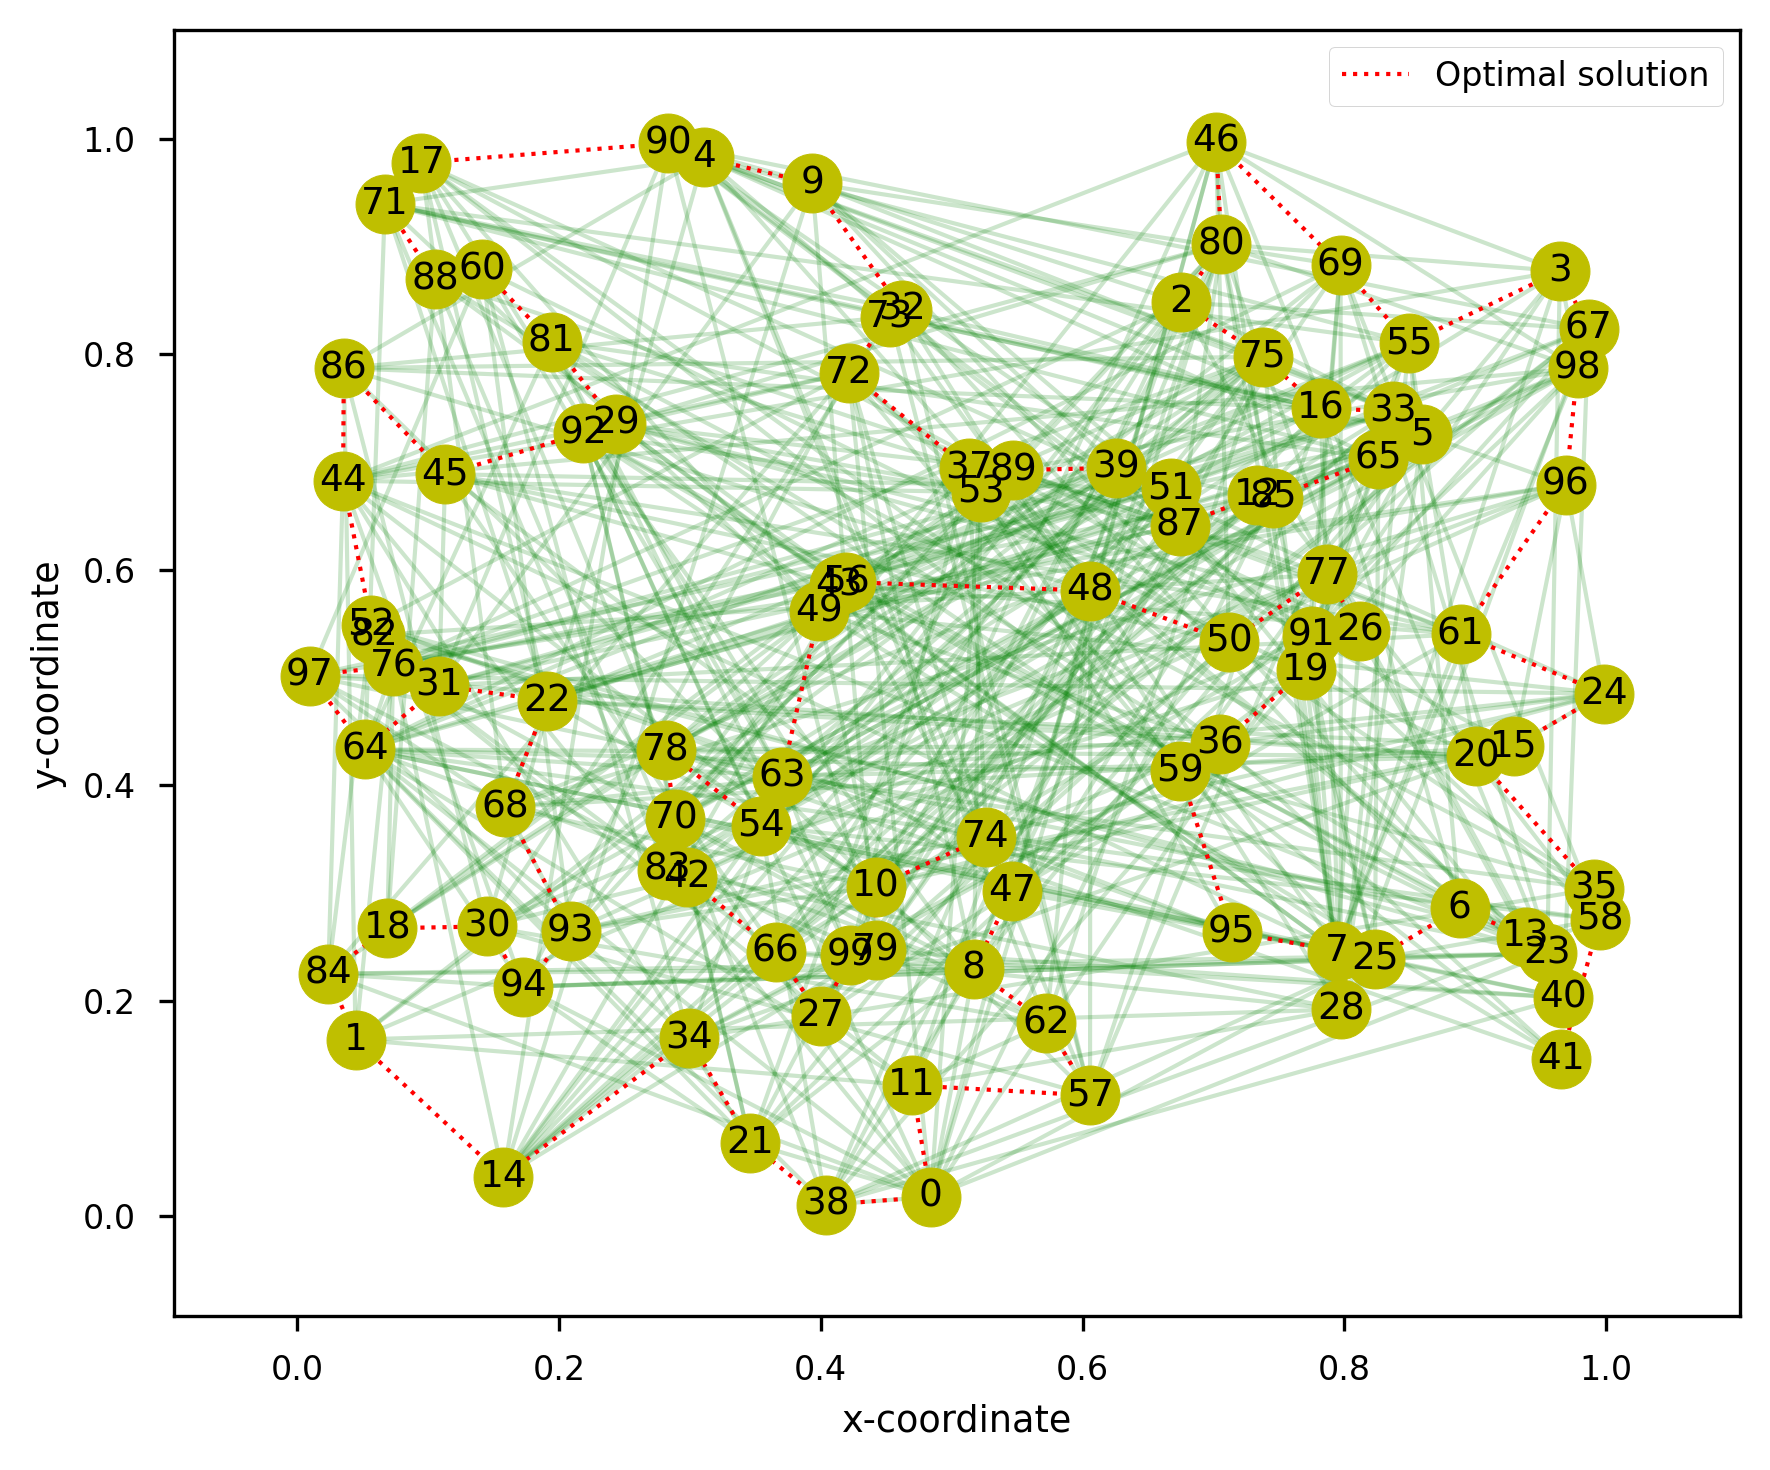

In [35]:
from main_code.utils.data.utils import convert_tsp_to_nx, calc_tour_length
index = 10
# plot heatmap
data = dataset[index]
node_coords = data[0]
opt_tour = data[2]
heatmap = data[-1]
g = convert_tsp_to_nx(node_coords)
plotter = TSP_plotter()
fig = plotter.plot_nx_graph(
    g, 
    opt_solution=opt_tour, 
    edge_probs=heatmap,
    draw_edges=False,
    dpi=300)

In [ ]:
# get original indices of the data and save corresponding heatmaps

# check whether heatmaps match / are reasonable
# add heapmaps to

In [ ]:
# convert data back to fu et al format
# use data as input to mcts for cpu
# analyze new heatmaps